<a href="https://colab.research.google.com/github/JhonaGo/BI-Tools/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Customer Lifetime Value With Probabilistic Model</h1></center>

*  https://www.pymc-marketing.io/en/latest/notebooks/clv/clv_quickstart.html
* https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gamma-gamma-model
*  https://github.com/ugursavci/Customer_Lifetime_Value_Prediction/tree/main
*  https://github.com/saritmaitra/Segmentation-Clustering/blob/master/CLTV.ipynb


### Business Problem

- An online company would like to know each customer lifetime value for 6 months and 12 months periods.
- We will utilize one of the Buy Till You Die model BG/NBD for predicting purchase amounts and then used Gamma-Gamma model to predict Customer Lifetime Value for desired periods.

### Importing Libraries

In [ ]:
!pip install lifetimes

In [ ]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Bases/Online_Retail.csv')

#### Data Understanding

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 30.2+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


### Data Preprocessing

In [ ]:
df = df[df['Quantity'] > 0 ]
df = df[df['UnitPrice'] > 0]
df = df[~df['InvoiceNo'].str.contains("C",na=False)] # drop returned items

#### Missing Values


In [ ]:
df.dropna(inplace=True)

#### Handling Outliers

In [ ]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [ ]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,8.348212,2.651029,15552.486392
std,9.245021,2.248187,1594.527150
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,36.000000,8.500000,18287.000000


#### Filtering only United Kingdom for Country

In [ ]:
df = df[df.Country == 'United Kingdom']

In [ ]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12.0,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8.0,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24.0,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24.0,2011-12-09 12:49:00,8.50,13113.0,United Kingdom
495477,581586,20685,DOORMAT RED RETROSPOT,10.0,2011-12-09 12:49:00,7.08,13113.0,United Kingdom


array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'UnitPrice'}>],
       [<Axes: title={'center': 'CustomerID'}>, <Axes: >]], dtype=object)

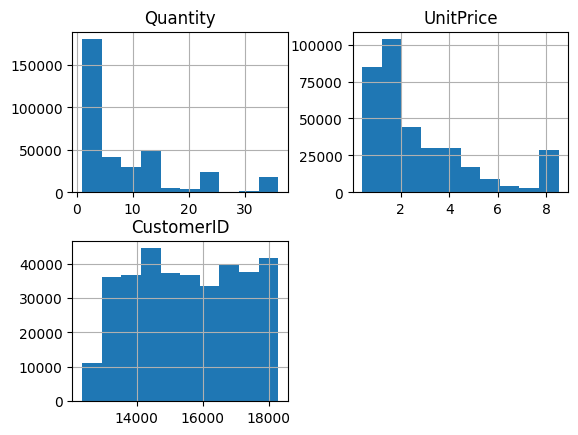

In [ ]:
df.hist()

#### Creating Column 'Total Price'

In [ ]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Creating Summary Dataset

By using lifetimes we can also create our RFM data from the original dataset.

- **Frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

- **Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

- **Monetary_Value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [ ]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,
                                                         'CustomerID','InvoiceDate','Total Price',
                                                         observation_period_end='2011-12-09')

In [ ]:
clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times

clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333
12823.0,4.0,222.0,296.0,252.450000


### BG/NBD Model for Predicting Number of Purchase

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(clv['frequency'],
        clv['recency'],
        clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1738 subjects, a: 0.02, alpha: 115.78, b: 14.10, r: 2.47>

In [ ]:
bgf_m = lifetimes.ModifiedBetaGeoFitter(penalizer_coef=0.001)

bgf_m.fit(clv['frequency'],
        clv['recency'],
        clv['T'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.ModifiedBetaGeoFitter: fitted with 1738 subjects, a: 0.00, alpha: 112.07, b: 0.00, r: 2.38>

#### Summary of BG/NBD Model

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.473902,0.109917,2.258465,2.689340
alpha,115.777000,5.650310,104.702394,126.851607
a,0.020563,0.029458,-0.037174,0.078300
b,14.097887,22.214587,-29.442704,57.638478


### Visualizing our Frequency/Recency Matrix

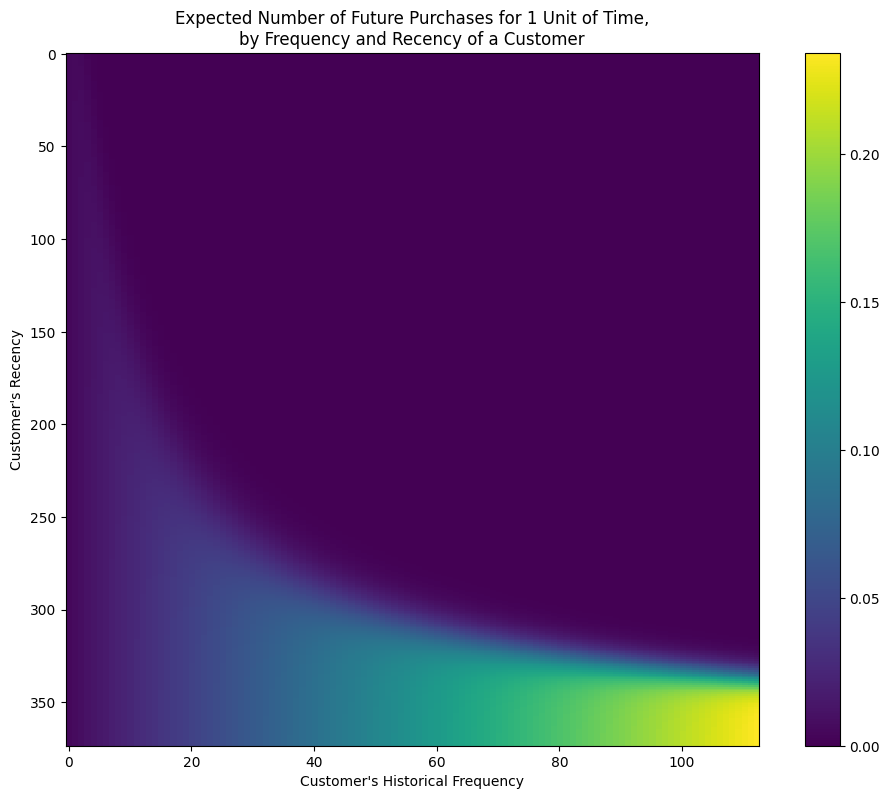

In [ ]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

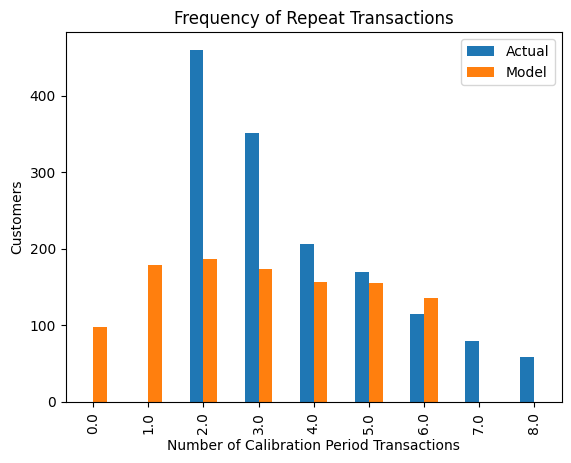

In [ ]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

#### Expected Number of Purchases in 6 Months

In [ ]:
t = 180 # 30 day period

clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])

clv.sort_values(by='expected_purc_6_months',ascending=False).tail(10)

,frequency,recency,T,monetary_value,expected_purc_6_months
CustomerID,,,,,
15574.0,2.0,195.0,372.0,148.725,1.629318
15525.0,2.0,371.0,373.0,254.030,1.625959
13705.0,2.0,366.0,373.0,196.860,1.625959
15485.0,2.0,343.0,373.0,778.615,1.625959
17951.0,2.0,334.0,373.0,243.540,1.625959
14001.0,2.0,328.0,373.0,562.220,1.625959
17420.0,2.0,323.0,373.0,221.090,1.625959
14045.0,2.0,264.0,373.0,411.300,1.625959
17897.0,2.0,201.0,373.0,166.595,1.625959


#### Expected Number of Purchases ın 12 Months

In [ ]:
#t = 360
#clv['expected_purc_12_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
#clv.sort_values(by='expected_purc_12_months',ascending=False).head(10)

### Gamma - Gamma Model

The Gamma-Gamma Model can predict the most likely value per transaction in the future

#### Assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [ ]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.082631
monetary_value,0.082631,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)         # 0.001 to 0.1 are effective
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1738 subjects, p: 3.80, q: 0.35, v: 3.73>

We can now estimate the average transaction value:

In [ ]:
print(ggf.conditional_expected_average_profit(
        clv["frequency"],
        clv["monetary_value"]
    ).head(5))

CustomerID
12747.0     382.667379
12748.0     257.743296
12749.0    1061.066198
12820.0     273.466049
12823.0     264.745282
dtype: float64


### 6 months Customer Lifetime Value

In [ ]:
clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)

#### Segmentation Customers by 6 Months CLV

In [ ]:
clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])

In [ ]:
clv.tail()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV,Segment
CustomerID,,,,,,,
18263.0,2.0,227.0,252.0,467.580000,2.166345,1074.547597,Loyal Customers
18272.0,5.0,244.0,246.0,485.688000,3.710709,1805.476473,Champions
18273.0,2.0,255.0,257.0,71.400000,2.136996,165.434190,Hibernating
18283.0,13.0,334.0,337.0,152.436154,6.165368,921.670085,Need Attention
18287.0,2.0,159.0,201.0,493.940000,2.519243,1319.757760,Loyal Customers


### Final Dataframe

In [ ]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customers,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737


### Group by Segment

In [ ]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_CLV
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customers,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737


### More model fitting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=42)

In [ ]:
train_df['InvoiceDate'].max()

'2011-12-09 12:49:00'

In [ ]:
test_df['InvoiceDate'].min()

#test_df['InvoiceDate'].max()

'2010-12-01 08:26:00'

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Total Price'], dtype='object')

In [ ]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2010-12-01 08:26:00',
                                        observation_period_end='2011-12-09 12:49:00' )

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

  message: NaN result encountered.
  success: False
   status: 3
      fun: nan
        x: [ 1.000e-01  1.000e-01  1.000e-01  1.000e-01]
      nit: 0
      jac: [       nan        nan        nan        nan]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 1
     njev: 1


/usr/local/lib/python3.11/dist-packages/lifetimes/utils.py:397: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0 / age.max()
/usr/local/lib/python3.11/dist-packages/lifetimes/fitters/beta_geo_fitter.py:134: RuntimeWarning: invalid value encountered in multiply
  scaled_recency = recency * self._scale
/usr/local/lib/python3.11/dist-packages/lifetimes/fitters/beta_geo_fitter.py:135: RuntimeWarning: invalid value encountered in multiply
  scaled_T = T * self._scale


ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


## SECOND PART

https://towardsdatascience.com/pymc-marketing-the-key-to-advanced-clv-customer-lifetime-value-forecasting-bc0730973c0a/